<b>
<p>
<center>
<font size="6">
Machine Learning 1 Project
</font>
</center>
</p>
<br>
<p>

<center>
Worked on and submitted by:
</center>
    
1. Chinmay Patil
2. Dilip Verma
3. Juhi Sinha
4. Somanath Joglekar

<b>
<p>
<center>
<font size="6">
Prediction of Stock Prices Using Deep Learning Models
</font>
</center>
</p>
<br>
<p>
<font size="5">
Introduction
</font>
</p>
</b>

<p>
<font size="4">
Stock of a corporation, is all of the shares into which ownership of the corporation is divided. A single share of the stock represents fractional ownership of the corporation in proportion to the total number of shares. Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on an exchange. The prediction methods are divided into two main categories: technical and fundamental analysis. The goal of our project is to train a model on stock data and then use that model to perform prediction of the prices for the following year. 
</font>
</p>




In [15]:
import os
import numpy as np
import pandas as pd
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet

In [16]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Loading data files

In [17]:
def create_files_dict(pth='./data/'):                                     # Creating data files
    '''
    create dictionary of files
    '''
    # pull all data files
    files = os.listdir(pth)
    print(files)
    all_data = dict()
    for file in files:

        # create key and file path
        file_key = file.split('_')[0]
        file_path = os.path.join(pth, file)

        # read the data
        data = pd.read_csv(
            file_path,
            index_col='Date',
            parse_dates=['Date']
        )

        # store data in dictionary
        all_data[file_key] = data
    return all_data

## Saving the results

In [18]:
def plot_data(data, stock_name, pth='./figures/'):                                 # Saving the results
    '''
    plot the data
    '''
    # create train and test
    data["High"][:'2016'].plot(figsize=(16, 4), legend=True)
    data["High"]['2017':].plot(figsize=(16, 4), legend=True)

    # plot the data
    plt.legend(['Training set (Before 2017)', 'Test set (2017 and beyond)'])
    plt.title('{} stock price'.format(stock_name))
    fig_path = os.path.join(pth, stock_name + '_train_test')

    # save the data, pause, and close
    plt.savefig(fig_path)
    plt.pause(1)
    plt.close()

## Data Preprocessing

In [19]:
def create_dl_train_test_split(all_data):
    '''
    create training/testing data and scaler object
    '''
    # create training and test set
    training_set = all_data[:'2016'].iloc[:, 1:2].values
    test_set = all_data['2017':].iloc[:, 1:2].values

    # scale the data
    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    # create training and test data
    X_train = []
    y_train = []
    for i in range(60, 2768):
        X_train.append(training_set_scaled[i - 60:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    total_data = pd.concat(
        (all_data["High"][:'2016'], all_data["High"]['2017':]), axis=0)
    inputs = total_data[len(total_data) - len(test_set) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(60, 311):
        X_test.append(inputs[i - 60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_train, y_train, X_test, sc

## Deep Learning Models

### Recurrent Neural Networks (RNN)

#### Single layer recurrent network with 6 Nodes

In [20]:
def create_single_layer_small_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)
    return model, test_preds

#### Single layer recurrent network with 32 Nodes

In [21]:
def create_single_layer_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)
    return model, test_preds

#### Simple RNN Model

In [22]:
def create_rnn_model(X_train, y_train, X_test, sc):
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)
    return model, test_preds

### GRU Model

In [23]:
def create_GRU_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True,
                         input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(
        optimizer=SGD(
            lr=0.01,
            decay=1e-7,
            momentum=0.9,
            nesterov=False),
        loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)
    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
    return regressorGRU, GRU_predicted_stock_price

#### GRU Model using Dropout

In [24]:
def create_GRU_with_drop_out_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True,
                         input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    # Compiling the RNN
    regressorGRU.compile(
        optimizer=SGD(
            lr=0.01,
            decay=1e-7,
            momentum=0.9,
            nesterov=False),
        loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)
    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
    return regressorGRU, GRU_predicted_stock_price

### Prophet Model

In [25]:
def create_prophet_results(all_data,
                           final_train_idx=2768,
                           pred_periods=250):
    '''
    create prophet model trained on first 2768 rows by
    default and predicts on last 250 rows
    '''
    # Pull train data
    train_data = all_data[:final_train_idx].reset_index()[['Date', 'High']]
    train_data.columns = ['ds', 'y']

    # Create and fit model
    prophet_model = Prophet()
    prophet_model.fit(train_data)

    # Provide predictions
    test_dates = prophet_model.make_future_dataframe(periods=pred_periods)
    forecast_prices = prophet_model.predict(test_dates)
    return forecast_prices

In [26]:
def create_prophet_daily_results(data):
    '''
    '''
    test_results = pd.DataFrame()
    for val in range(2768, 3019):

        # format training dataframe
        df = data['High'][:val].reset_index()
        df.columns = ['ds', 'y']

        # Instantiate and fit the model
        proph_model = Prophet(daily_seasonality=True)
        proph_model.fit(df)

        # create test dataframe
        test_dates = proph_model.make_future_dataframe(periods=1)

        # store test results in dataframe
        preds = proph_model.predict(test_dates).tail(1)
        test_results = test_results.append(preds)
    return test_results

## Plotting the results

In [27]:
def plot_results(actuals,
                 stock_name,
                 small_one_layer_preds,
                 one_layer_preds,
                 yearly_prophet_preds,
                 gru_drop_preds,
                 rnn_preds,
                 gru_preds,
                 plot_pth='./figures'):
    '''
    plot the results
    '''
    plt.figure(figsize=(20, 5))
    plt.plot(yearly_prophet_preds.reset_index()[
             'yhat'].values[-250:], label='prophet yearly predictions')
    plt.plot(stock_data["High"]['2017':].values[:-1], label='actual values')
    plt.plot(small_one_layer_preds, label='Single Layer Small RNN values')
    plt.plot(one_layer_preds, label='Single Layer RNN values')
    plt.plot(gru_drop_preds, label='GRU with dropout values')
    plt.plot(rnn_preds, label='RNN values')
    plt.plot(gru_preds, label='GRU values')
    plt.title('{} Predictions from Prophet vs. Actual'.format(stock_name))
    plt.legend()
    fig_path = os.path.join(plot_pth, 'results', stock_name + '_preds')

    # save the data, pause, and close
    plt.savefig(fig_path)
    plt.pause(1)
    plt.close()

## Code to run all models

['JPM_2006-01-01_to_2018-01-01.csv', 'AMZN_2006-01-01_to_2018-01-01.csv', 'AAPL_2006-01-01_to_2018-01-01.csv', 'IBM_2006-01-01_to_2018-01-01.csv']


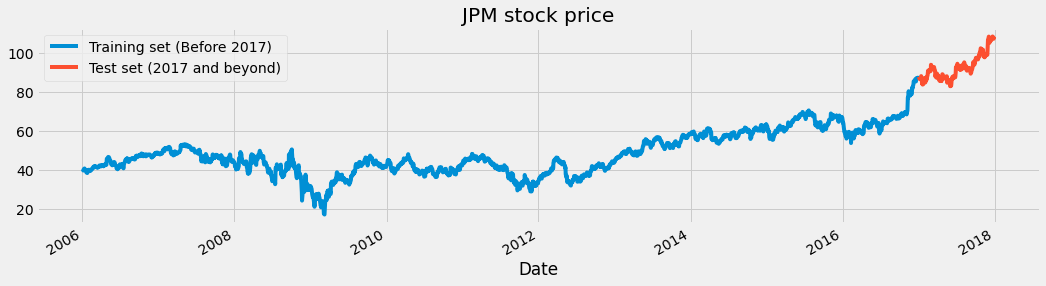

Epoch 1/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0076
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 11/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 12/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 13/100
19/19 [=================

19/19 [==============================] - 0s 6ms/step - loss: 2.2196e-04
Epoch 96/100
19/19 [==============================] - 0s 6ms/step - loss: 2.5088e-04
Epoch 97/100
19/19 [==============================] - 0s 6ms/step - loss: 2.2157e-04
Epoch 98/100
19/19 [==============================] - 0s 6ms/step - loss: 2.4346e-04
Epoch 99/100
19/19 [==============================] - 0s 6ms/step - loss: 2.0160e-04
Epoch 100/100
19/19 [==============================] - 0s 7ms/step - loss: 2.4014e-04
Epoch 1/100
19/19 [==============================] - 1s 28ms/step - loss: 0.2065
Epoch 2/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0330
Epoch 3/100
19/19 [==============================] - 1s 26ms/step - loss: 0.0283
Epoch 4/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0281
Epoch 5/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0233
Epoch 6/100
19/19 [==============================] - 0s 26ms/step - loss: 0.0190
Epoch 7/100
19/1

19/19 [==============================] - 2s 109ms/step - loss: 0.0014
Epoch 43/50
19/19 [==============================] - 2s 108ms/step - loss: 0.0013
Epoch 44/50
19/19 [==============================] - 2s 112ms/step - loss: 0.0012
Epoch 45/50
19/19 [==============================] - 2s 109ms/step - loss: 0.0013
Epoch 46/50
19/19 [==============================] - 2s 108ms/step - loss: 0.0013
Epoch 47/50
19/19 [==============================] - 2s 104ms/step - loss: 0.0012
Epoch 48/50
19/19 [==============================] - 2s 108ms/step - loss: 0.0013
Epoch 49/50
19/19 [==============================] - 2s 112ms/step - loss: 0.0013
Epoch 50/50
19/19 [==============================] - 2s 106ms/step - loss: 0.0013


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


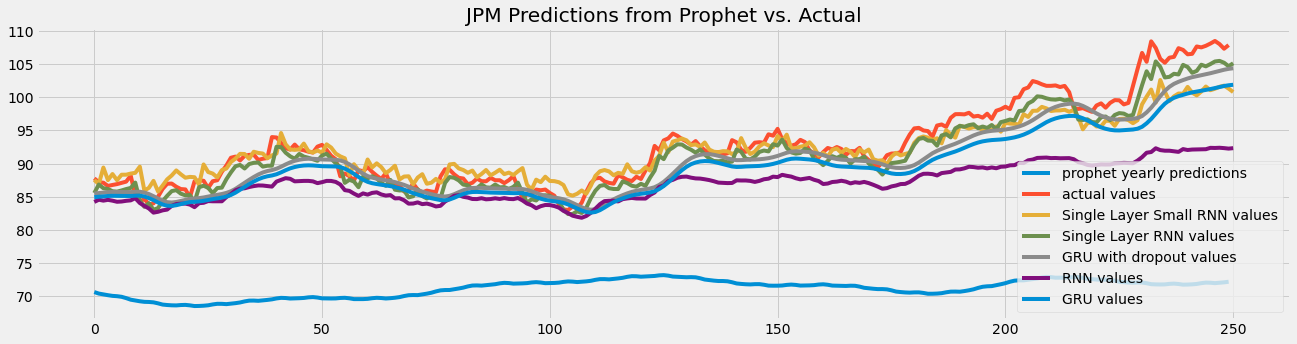

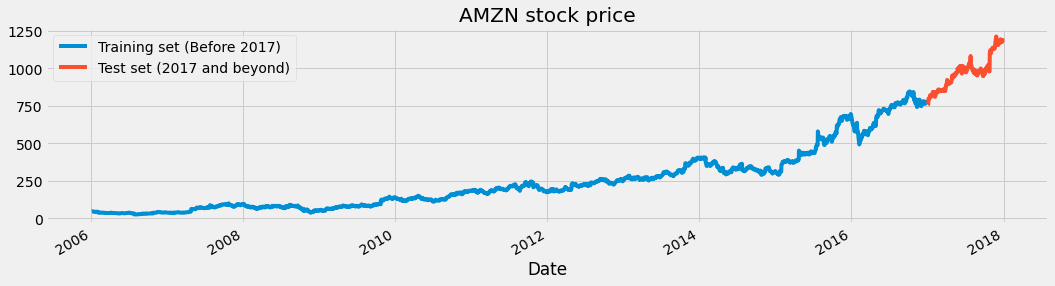

Epoch 1/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1004
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0180
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 8.0480e-04
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 6.2542e-04
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 5.6780e-04
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 4.7874e-04
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 4.3132e-04
Epoch 11/100
19/19 [==============================] - 0s 5ms/step - loss: 3.7247e-04
Epoch 12/100
19/19 [==============================] - 0s 5ms/step - loss: 3.5606e-04
Epoch 13/

19/19 [==============================] - 0s 6ms/step - loss: 6.6424e-05
Epoch 94/100
19/19 [==============================] - 0s 6ms/step - loss: 8.3726e-05
Epoch 95/100
19/19 [==============================] - 0s 6ms/step - loss: 7.7445e-05
Epoch 96/100
19/19 [==============================] - 0s 6ms/step - loss: 8.8146e-05
Epoch 97/100
19/19 [==============================] - 0s 7ms/step - loss: 8.3509e-05
Epoch 98/100
19/19 [==============================] - 0s 6ms/step - loss: 7.6302e-05
Epoch 99/100
19/19 [==============================] - 0s 6ms/step - loss: 7.8304e-05
Epoch 100/100
19/19 [==============================] - 0s 6ms/step - loss: 9.7258e-05
Epoch 1/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0761
Epoch 2/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0226
Epoch 3/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0116
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0101
Epoch 5/

19/19 [==============================] - 2s 118ms/step - loss: 0.0014
Epoch 40/50
19/19 [==============================] - 2s 117ms/step - loss: 0.0013
Epoch 41/50
19/19 [==============================] - 2s 113ms/step - loss: 0.0014
Epoch 42/50
19/19 [==============================] - 2s 106ms/step - loss: 0.0013
Epoch 43/50
19/19 [==============================] - 2s 117ms/step - loss: 0.0015
Epoch 44/50
19/19 [==============================] - 2s 111ms/step - loss: 0.0012
Epoch 45/50
19/19 [==============================] - 2s 108ms/step - loss: 0.0013
Epoch 46/50
19/19 [==============================] - 2s 113ms/step - loss: 0.0013
Epoch 47/50
19/19 [==============================] - 2s 103ms/step - loss: 0.0013
Epoch 48/50
19/19 [==============================] - 2s 105ms/step - loss: 0.0013
Epoch 49/50
19/19 [==============================] - 2s 113ms/step - loss: 0.0012
Epoch 50/50
19/19 [==============================] - 2s 109ms/step - loss: 0.0013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


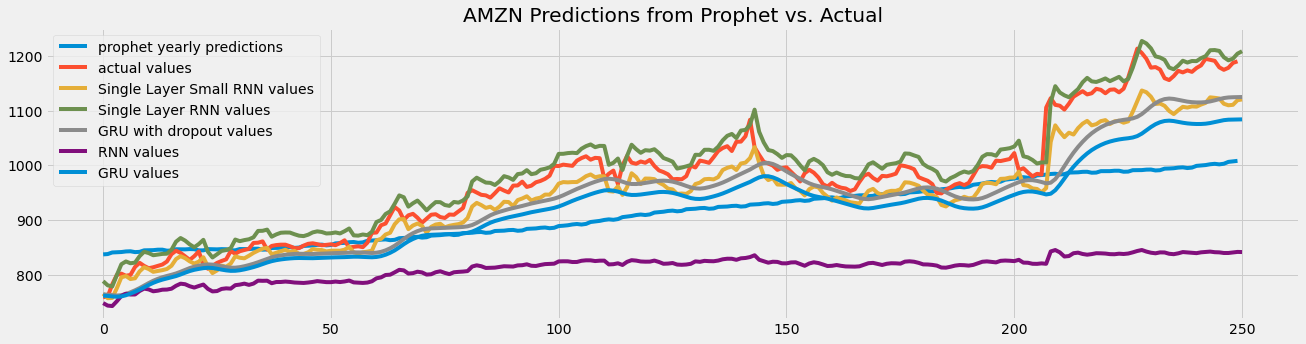

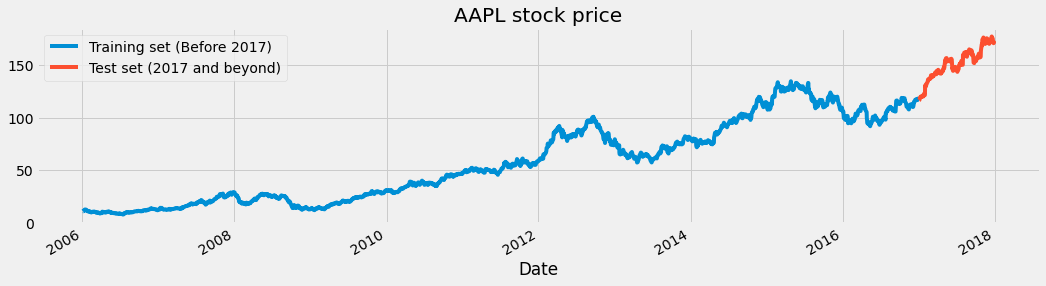

Epoch 1/100
19/19 [==============================] - 0s 5ms/step - loss: 0.3747
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0972
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 11/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 12/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 13/100
19/19 [=================

19/19 [==============================] - 0s 7ms/step - loss: 1.0447e-04
Epoch 96/100
19/19 [==============================] - 0s 7ms/step - loss: 9.7105e-05
Epoch 97/100
19/19 [==============================] - 0s 7ms/step - loss: 9.1304e-05
Epoch 98/100
19/19 [==============================] - 0s 7ms/step - loss: 1.0133e-04
Epoch 99/100
19/19 [==============================] - 0s 7ms/step - loss: 9.4210e-05
Epoch 100/100
19/19 [==============================] - 0s 7ms/step - loss: 9.5769e-05
Epoch 1/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0833
Epoch 2/100
19/19 [==============================] - 1s 32ms/step - loss: 0.0193
Epoch 3/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0216
Epoch 4/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0145
Epoch 5/100
19/19 [==============================] - 1s 31ms/step - loss: 0.0126
Epoch 6/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0137
Epoch 7/100
19/1

19/19 [==============================] - 2s 114ms/step - loss: 0.0019
Epoch 42/50
19/19 [==============================] - 2s 114ms/step - loss: 0.0020
Epoch 43/50
19/19 [==============================] - 2s 112ms/step - loss: 0.0020
Epoch 44/50
19/19 [==============================] - 2s 110ms/step - loss: 0.0018
Epoch 45/50
19/19 [==============================] - 2s 106ms/step - loss: 0.0017
Epoch 46/50
19/19 [==============================] - 2s 110ms/step - loss: 0.0017
Epoch 47/50
19/19 [==============================] - 2s 110ms/step - loss: 0.0017
Epoch 48/50
19/19 [==============================] - 2s 124ms/step - loss: 0.0019
Epoch 49/50
19/19 [==============================] - 3s 143ms/step - loss: 0.0018
Epoch 50/50
19/19 [==============================] - 4s 201ms/step - loss: 0.0018


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


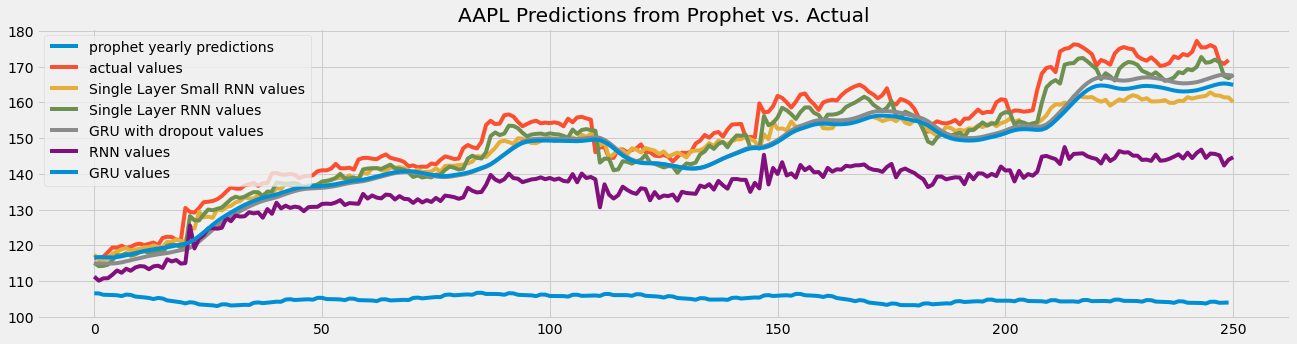

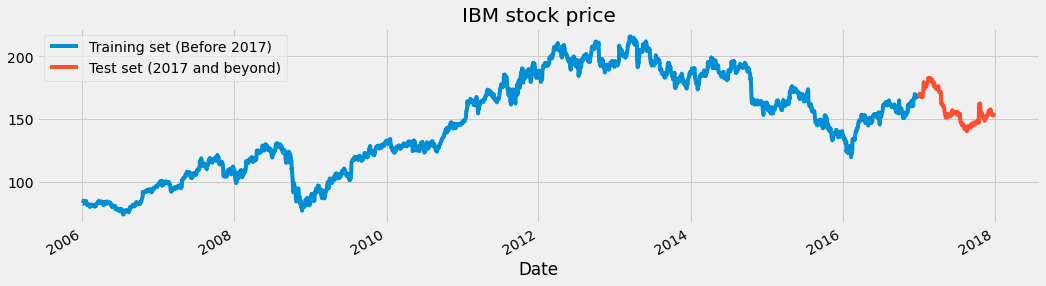

Epoch 1/100
19/19 [==============================] - 0s 6ms/step - loss: 0.6274
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1378
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0557
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0292
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 10/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 11/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 12/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 13/100
19/19 [=================

19/19 [==============================] - 0s 6ms/step - loss: 2.1064e-04
Epoch 96/100
19/19 [==============================] - 0s 6ms/step - loss: 2.0945e-04
Epoch 97/100
19/19 [==============================] - 0s 6ms/step - loss: 2.0904e-04
Epoch 98/100
19/19 [==============================] - 0s 6ms/step - loss: 2.1066e-04
Epoch 99/100
19/19 [==============================] - 0s 6ms/step - loss: 2.1831e-04
Epoch 100/100
19/19 [==============================] - 0s 6ms/step - loss: 2.1009e-04
Epoch 1/100
19/19 [==============================] - 1s 36ms/step - loss: 0.0875
Epoch 2/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0239
Epoch 3/100
19/19 [==============================] - 1s 32ms/step - loss: 0.0178
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0201
Epoch 5/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0146
Epoch 6/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0173
Epoch 7/100
19/1

19/19 [==============================] - 2s 107ms/step - loss: 0.0022
Epoch 43/50
19/19 [==============================] - 2s 105ms/step - loss: 0.0022
Epoch 44/50
19/19 [==============================] - 2s 105ms/step - loss: 0.0022
Epoch 45/50
19/19 [==============================] - 2s 106ms/step - loss: 0.0021
Epoch 46/50
19/19 [==============================] - 2s 109ms/step - loss: 0.0021
Epoch 47/50
19/19 [==============================] - 2s 106ms/step - loss: 0.0021
Epoch 48/50
19/19 [==============================] - 2s 105ms/step - loss: 0.0022
Epoch 49/50
19/19 [==============================] - 2s 104ms/step - loss: 0.0020
Epoch 50/50
19/19 [==============================] - 2s 106ms/step - loss: 0.0021


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


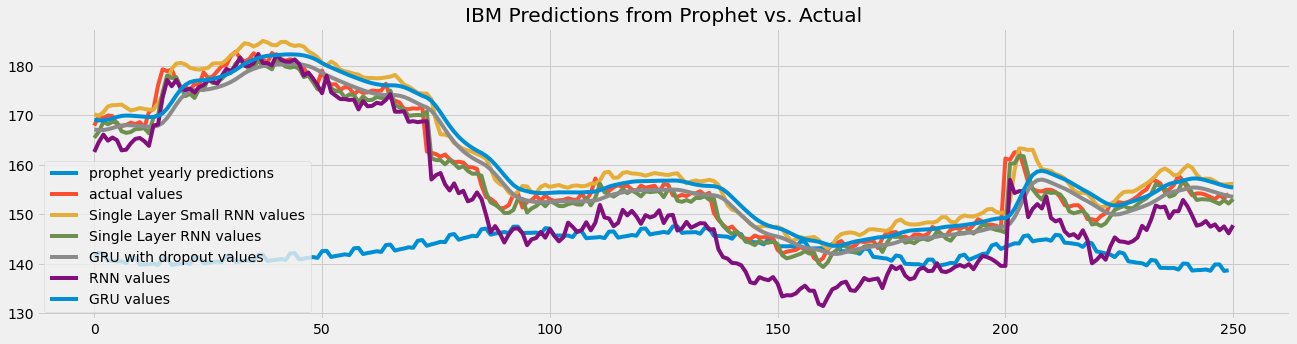

In [28]:
if __name__ == '__main__':
    all_data = create_files_dict()
    for stock_name, stock_data in all_data.items():
        # initial plots
        plot_data(stock_data, stock_name)

        # create dl data
        X_train, y_train, X_test, sc = create_dl_train_test_split(stock_data)

        # create small single layer small rnn preds
        small_single_layer_rnn, small_one_layer_preds = create_single_layer_small_rnn_model(
            X_train, y_train, X_test, sc)

        # create single layer rnn preds
        single_layer_rnn, one_layer_preds = create_single_layer_rnn_model(
            X_train, y_train, X_test, sc)

        # rnn daily preds
        rnn_model, rnn_preds = create_rnn_model(X_train, y_train, X_test, sc)

        # gru daily preds
        gru_model, gru_preds = create_GRU_model(X_train, y_train, X_test, sc)

        # gru daily preds
        gru_drop_model, gru_drop_preds = create_GRU_with_drop_out_model(
            X_train, y_train, X_test, sc)

        # yearly preds
        yearly_preds = create_prophet_results(stock_data)

        # daily preds
        # prophet_daily_preds = create_prophet_daily_results(stock_data)

        # plot results
        plot_results(stock_data,
                     stock_name,
                     small_one_layer_preds,
                     one_layer_preds,
                     yearly_preds,
                     gru_drop_preds,
                     rnn_preds,
                     gru_preds)

## **Conclusion**




We implemented deep learning models such as RNN model and GRU model for predicting stock prices. We further improved the performance of these models by varying some parameters such as adding layers, dropouts etc. Moreover, we also used facebook prophet model for predicting stock prices. we did a few runs to make the prophet model directly comparable to the recurrent models used above, but these models take a significant amount of time to run. As a result, the single layer RNN model(Green line from figure) is the best model when compared with all the models listed above.
